In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import os
import matplotlib.pyplot as plt
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.training import moving_averages
import keras
import scipy.ndimage as ndi
from PIL import Image as pil_image
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [2]:
def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x

def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

def apply_transform(x,
                    transform_matrix,
                    channel_axis=0,
                    fill_mode='nearest',
                    cval=0.):
    """Apply the image transformation specified by a matrix.

  Arguments:
      x: 2D numpy array, single image.
      transform_matrix: Numpy array specifying the geometric transformation.
      channel_axis: Index of axis for channels in the input tensor.
      fill_mode: Points outside the boundaries of the input
          are filled according to the given mode
          (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
      cval: Value used for points outside the boundaries
          of the input if `mode='constant'`.

  Returns:
      The transformed version of the input.
  """
    x = np.rollaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [
      ndi.interpolation.affine_transform(
          x_channel,
          final_affine_matrix,
          final_offset,
          order=0,
          mode=fill_mode,
          cval=cval) for x_channel in x
    ]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

In [3]:
def random_transform(x):
    transform_matrix=None
    
    """Randomly augment a single image tensor.

    Arguments:
        x: 3D tensor, single image.

    Returns:
        A randomly transformed version of the input (same shape).

    Raises:
        ImportError: if Scipy is not available.
    """

    # x is a single image, so it doesn't have image number at index 0
    channel_axis = 3
    row_axis = 1
    col_axis = 2
    img_row_axis = row_axis - 1
    img_col_axis = col_axis - 1
    img_channel_axis = channel_axis - 1

    # use composition of homographies
    # to generate final transform that needs to be applied
    if True:
        tx = np.random.uniform(-0.125,
                             0.125) * x.shape[img_row_axis]
    else:
        tx = 0

    if True:
        ty = np.random.uniform(-0.125,
                             0.125) * x.shape[img_col_axis]
    else:
        ty = 0
    if tx != 0 or ty != 0:
        shift_matrix = np.array([[1, 0, tx], [0, 1, ty], [0, 0, 1]])
        if transform_matrix is None:
            transform_matrix = shift_matrix
        else:
            transform_matrix=np.dot(transform_matrix, shift_matrix)
    if transform_matrix is not None:
        h, w = x.shape[img_row_axis], x.shape[img_col_axis]
        transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
        x = apply_transform(
          x,
          transform_matrix,
          img_channel_axis)
    if True:
        if np.random.random() < 0.5:
            x = flip_axis(x, img_col_axis)
    return x

In [4]:
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [5]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            
            X_batch=Xd[idx,:]
            y_batch=yd[idx]
            for i in range(yd[idx].shape[0]):
                X_batch[i,:]=random_transform(X_batch[i,:])
            
            # create a feed dictionary for this batch
            feed_dict = {X: X_batch,
                         y: y_batch,
                         is_training: training_now }
            #feed_dict = {X: Xd[idx,:],
            #             y: yd[idx],
            #             is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

In [6]:
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

In [7]:
from resnet_new import *
def my_model(X,is_training):
    logits=resnet(x=X,is_training=is_training)
    return logits
y_out = my_model(X,is_training)
total_loss= tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10),logits=y_out)+tf.losses.get_regularization_loss()
mean_loss = tf.reduce_mean(total_loss)
global_step = tf.Variable(0, trainable=False, name="Global_Step")
boundaries = [6400,12800]
values=[0.001,0.0001,0.00001]
learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)
#learning_rate = tf.train.exponential_decay(0.001, global_step,  1000,  decay_rate=0.9,staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [ ]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss,global_step=global_step) #apply the learning rate decay

Training
Iteration 0: with minibatch training loss = 5.41 and accuracy of 0.047
Iteration 100: with minibatch training loss = 2.01 and accuracy of 0.25
Iteration 200: with minibatch training loss = 1.85 and accuracy of 0.41
Iteration 300: with minibatch training loss = 1.82 and accuracy of 0.41
Iteration 400: with minibatch training loss = 1.4 and accuracy of 0.47
Iteration 500: with minibatch training loss = 1.59 and accuracy of 0.5
Iteration 600: with minibatch training loss = 1.78 and accuracy of 0.42
Iteration 700: with minibatch training loss = 1.44 and accuracy of 0.44
Epoch 1, Overall loss = 1.84 and accuracy of 0.37


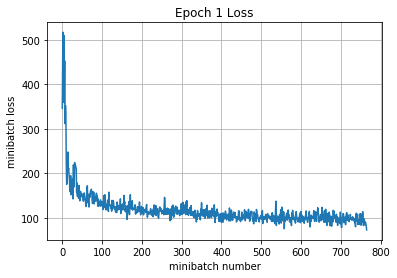

Iteration 800: with minibatch training loss = 1.5 and accuracy of 0.42
Iteration 900: with minibatch training loss = 1.32 and accuracy of 0.58
Iteration 1000: with minibatch training loss = 1.39 and accuracy of 0.48
Iteration 1100: with minibatch training loss = 1.62 and accuracy of 0.44
Iteration 1200: with minibatch training loss = 1.43 and accuracy of 0.44
Iteration 1300: with minibatch training loss = 1.17 and accuracy of 0.55
Iteration 1400: with minibatch training loss = 1.15 and accuracy of 0.53
Iteration 1500: with minibatch training loss = 1.18 and accuracy of 0.67
Epoch 2, Overall loss = 1.35 and accuracy of 0.514


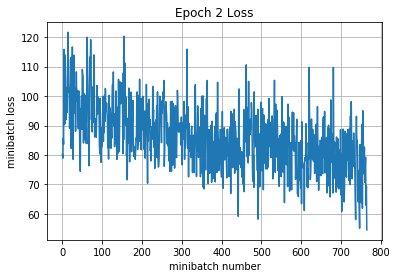

Iteration 1600: with minibatch training loss = 1.37 and accuracy of 0.47
Iteration 1700: with minibatch training loss = 1.11 and accuracy of 0.67
Iteration 1800: with minibatch training loss = 0.987 and accuracy of 0.55
Iteration 1900: with minibatch training loss = 1.06 and accuracy of 0.67
Iteration 2000: with minibatch training loss = 1.24 and accuracy of 0.47
Iteration 2100: with minibatch training loss = 1.13 and accuracy of 0.61
Iteration 2200: with minibatch training loss = 1.02 and accuracy of 0.61
Epoch 3, Overall loss = 1.13 and accuracy of 0.594


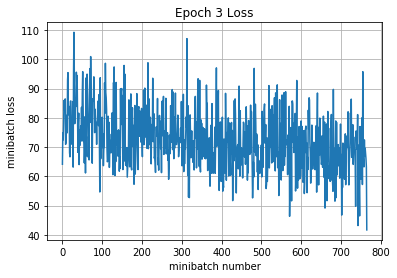

Iteration 2300: with minibatch training loss = 0.953 and accuracy of 0.66
Iteration 2400: with minibatch training loss = 1.03 and accuracy of 0.59
Iteration 2500: with minibatch training loss = 1.25 and accuracy of 0.52
Iteration 2600: with minibatch training loss = 0.927 and accuracy of 0.69
Iteration 2700: with minibatch training loss = 1.14 and accuracy of 0.58
Iteration 2800: with minibatch training loss = 1.1 and accuracy of 0.64
Iteration 2900: with minibatch training loss = 0.975 and accuracy of 0.69
Iteration 3000: with minibatch training loss = 0.781 and accuracy of 0.73
Epoch 4, Overall loss = 1 and accuracy of 0.642


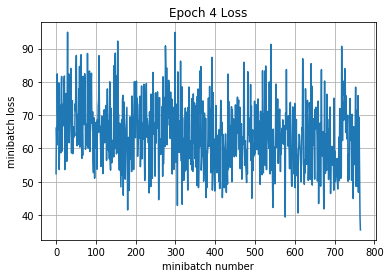

Iteration 3100: with minibatch training loss = 1.19 and accuracy of 0.55
Iteration 3200: with minibatch training loss = 0.906 and accuracy of 0.67
Iteration 3300: with minibatch training loss = 0.75 and accuracy of 0.69
Iteration 3400: with minibatch training loss = 0.824 and accuracy of 0.67
Iteration 3500: with minibatch training loss = 0.74 and accuracy of 0.78
Iteration 3600: with minibatch training loss = 1.04 and accuracy of 0.67
Iteration 3700: with minibatch training loss = 0.666 and accuracy of 0.77
Iteration 3800: with minibatch training loss = 0.686 and accuracy of 0.77
Epoch 5, Overall loss = 0.819 and accuracy of 0.709


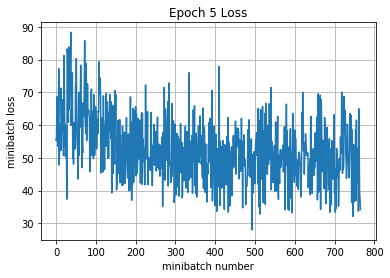

Iteration 3900: with minibatch training loss = 0.853 and accuracy of 0.69
Iteration 4000: with minibatch training loss = 0.893 and accuracy of 0.67
Iteration 4100: with minibatch training loss = 0.652 and accuracy of 0.78
Iteration 4200: with minibatch training loss = 0.624 and accuracy of 0.81
Iteration 4300: with minibatch training loss = 0.822 and accuracy of 0.7
Iteration 4400: with minibatch training loss = 0.805 and accuracy of 0.7
Iteration 4500: with minibatch training loss = 0.825 and accuracy of 0.72
Epoch 6, Overall loss = 0.739 and accuracy of 0.736


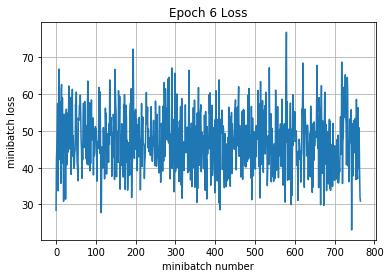

Iteration 4600: with minibatch training loss = 0.793 and accuracy of 0.72
Iteration 4700: with minibatch training loss = 0.669 and accuracy of 0.8
Iteration 4800: with minibatch training loss = 0.644 and accuracy of 0.73
Iteration 4900: with minibatch training loss = 0.82 and accuracy of 0.69
Iteration 5000: with minibatch training loss = 0.642 and accuracy of 0.72
Iteration 5100: with minibatch training loss = 0.675 and accuracy of 0.77
Iteration 5200: with minibatch training loss = 0.625 and accuracy of 0.78
Iteration 5300: with minibatch training loss = 0.636 and accuracy of 0.7
Epoch 7, Overall loss = 0.706 and accuracy of 0.75


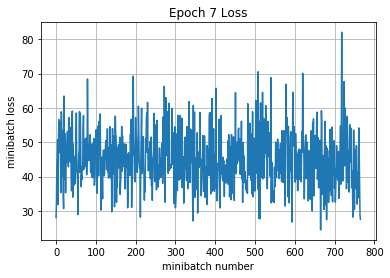

Iteration 5400: with minibatch training loss = 0.589 and accuracy of 0.78
Iteration 5500: with minibatch training loss = 0.652 and accuracy of 0.75
Iteration 5600: with minibatch training loss = 0.828 and accuracy of 0.7
Iteration 5700: with minibatch training loss = 0.795 and accuracy of 0.78
Iteration 5800: with minibatch training loss = 0.657 and accuracy of 0.72
Iteration 5900: with minibatch training loss = 0.651 and accuracy of 0.75
Iteration 6000: with minibatch training loss = 0.785 and accuracy of 0.73
Iteration 6100: with minibatch training loss = 0.727 and accuracy of 0.75
Epoch 8, Overall loss = 0.681 and accuracy of 0.76


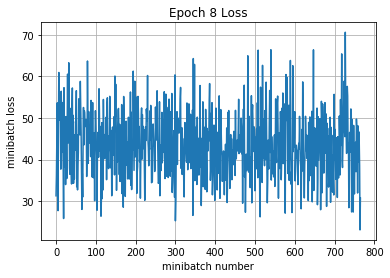

Iteration 6200: with minibatch training loss = 0.876 and accuracy of 0.7
Iteration 6300: with minibatch training loss = 0.631 and accuracy of 0.8
Iteration 6400: with minibatch training loss = 0.793 and accuracy of 0.67
Iteration 6500: with minibatch training loss = 0.552 and accuracy of 0.83
Iteration 6600: with minibatch training loss = 0.686 and accuracy of 0.77
Iteration 6700: with minibatch training loss = 0.695 and accuracy of 0.73
Iteration 6800: with minibatch training loss = 0.679 and accuracy of 0.75
Epoch 9, Overall loss = 0.659 and accuracy of 0.767


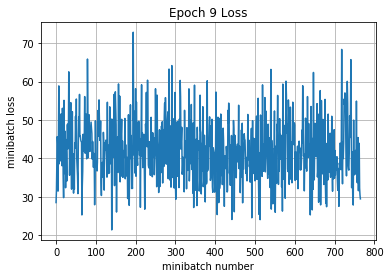

Iteration 6900: with minibatch training loss = 0.676 and accuracy of 0.8
Iteration 7000: with minibatch training loss = 0.708 and accuracy of 0.75
Iteration 7100: with minibatch training loss = 0.726 and accuracy of 0.77
Iteration 7200: with minibatch training loss = 0.934 and accuracy of 0.64
Iteration 7300: with minibatch training loss = 0.503 and accuracy of 0.75
Iteration 7400: with minibatch training loss = 0.765 and accuracy of 0.72
Iteration 7500: with minibatch training loss = 0.609 and accuracy of 0.77
Iteration 7600: with minibatch training loss = 0.608 and accuracy of 0.77
Epoch 10, Overall loss = 0.635 and accuracy of 0.776


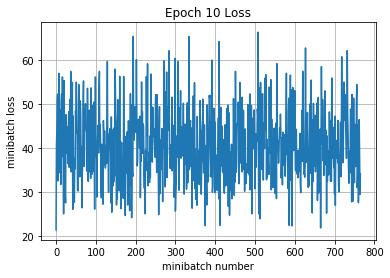

Iteration 7700: with minibatch training loss = 0.73 and accuracy of 0.8
Iteration 7800: with minibatch training loss = 0.398 and accuracy of 0.89
Iteration 7900: with minibatch training loss = 0.619 and accuracy of 0.8
Iteration 8000: with minibatch training loss = 0.749 and accuracy of 0.7
Iteration 8100: with minibatch training loss = 0.564 and accuracy of 0.77
Iteration 8200: with minibatch training loss = 0.737 and accuracy of 0.75
Iteration 8300: with minibatch training loss = 0.611 and accuracy of 0.78
Iteration 8400: with minibatch training loss = 0.603 and accuracy of 0.77
Epoch 11, Overall loss = 0.617 and accuracy of 0.78


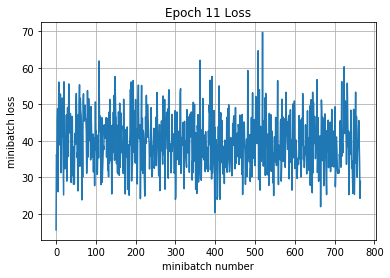

Iteration 8500: with minibatch training loss = 0.723 and accuracy of 0.8
Iteration 8600: with minibatch training loss = 0.436 and accuracy of 0.86
Iteration 8700: with minibatch training loss = 0.586 and accuracy of 0.77
Iteration 8800: with minibatch training loss = 0.568 and accuracy of 0.78
Iteration 8900: with minibatch training loss = 0.665 and accuracy of 0.8
Iteration 9000: with minibatch training loss = 0.744 and accuracy of 0.77
Iteration 9100: with minibatch training loss = 0.511 and accuracy of 0.86
Epoch 12, Overall loss = 0.603 and accuracy of 0.787


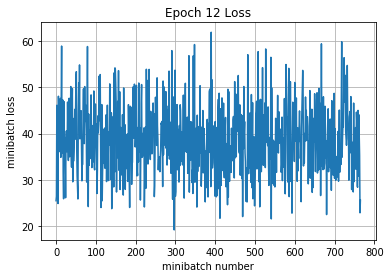

Iteration 9200: with minibatch training loss = 0.496 and accuracy of 0.81
Iteration 9300: with minibatch training loss = 0.825 and accuracy of 0.67
Iteration 9400: with minibatch training loss = 0.734 and accuracy of 0.83
Iteration 9500: with minibatch training loss = 0.562 and accuracy of 0.8
Iteration 9600: with minibatch training loss = 0.61 and accuracy of 0.78
Iteration 9700: with minibatch training loss = 0.823 and accuracy of 0.69
Iteration 9800: with minibatch training loss = 0.47 and accuracy of 0.81
Iteration 9900: with minibatch training loss = 0.496 and accuracy of 0.84
Epoch 13, Overall loss = 0.583 and accuracy of 0.795


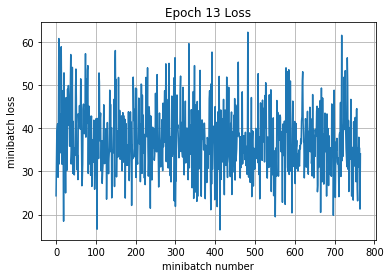

Iteration 10000: with minibatch training loss = 0.388 and accuracy of 0.86
Iteration 10100: with minibatch training loss = 0.622 and accuracy of 0.73
Iteration 10200: with minibatch training loss = 0.44 and accuracy of 0.86
Iteration 10300: with minibatch training loss = 0.429 and accuracy of 0.81
Iteration 10400: with minibatch training loss = 0.383 and accuracy of 0.88
Iteration 10500: with minibatch training loss = 0.714 and accuracy of 0.69
Iteration 10600: with minibatch training loss = 0.479 and accuracy of 0.84
Iteration 10700: with minibatch training loss = 0.497 and accuracy of 0.86
Epoch 14, Overall loss = 0.555 and accuracy of 0.805


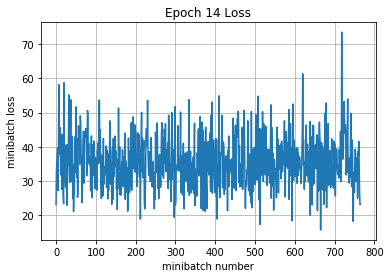

Iteration 10800: with minibatch training loss = 0.702 and accuracy of 0.81
Iteration 10900: with minibatch training loss = 0.523 and accuracy of 0.83
Iteration 11000: with minibatch training loss = 0.808 and accuracy of 0.72
Iteration 11100: with minibatch training loss = 0.413 and accuracy of 0.86
Iteration 11200: with minibatch training loss = 0.426 and accuracy of 0.84
Iteration 11300: with minibatch training loss = 0.37 and accuracy of 0.86
Iteration 11400: with minibatch training loss = 0.675 and accuracy of 0.73
Epoch 15, Overall loss = 0.556 and accuracy of 0.804


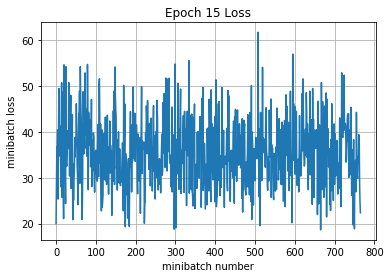

Iteration 11500: with minibatch training loss = 0.68 and accuracy of 0.78
Iteration 11600: with minibatch training loss = 0.643 and accuracy of 0.81
Iteration 11700: with minibatch training loss = 0.556 and accuracy of 0.78
Iteration 11800: with minibatch training loss = 0.66 and accuracy of 0.67
Iteration 11900: with minibatch training loss = 0.618 and accuracy of 0.81
Iteration 12000: with minibatch training loss = 0.415 and accuracy of 0.83
Iteration 12100: with minibatch training loss = 0.563 and accuracy of 0.77
Iteration 12200: with minibatch training loss = 0.417 and accuracy of 0.88
Epoch 16, Overall loss = 0.545 and accuracy of 0.81


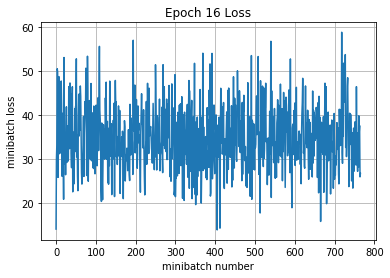

Iteration 12300: with minibatch training loss = 0.329 and accuracy of 0.91
Iteration 12400: with minibatch training loss = 0.678 and accuracy of 0.73
Iteration 12500: with minibatch training loss = 0.508 and accuracy of 0.78
Iteration 12600: with minibatch training loss = 0.406 and accuracy of 0.83
Iteration 12700: with minibatch training loss = 0.305 and accuracy of 0.89
Iteration 12800: with minibatch training loss = 0.615 and accuracy of 0.77
Iteration 12900: with minibatch training loss = 0.365 and accuracy of 0.83
Iteration 13000: with minibatch training loss = 0.504 and accuracy of 0.84
Epoch 17, Overall loss = 0.542 and accuracy of 0.809


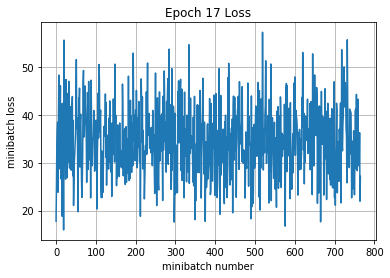

Iteration 13100: with minibatch training loss = 0.513 and accuracy of 0.83
Iteration 13200: with minibatch training loss = 0.362 and accuracy of 0.88
Iteration 13300: with minibatch training loss = 0.658 and accuracy of 0.75
Iteration 13400: with minibatch training loss = 0.42 and accuracy of 0.83
Iteration 13500: with minibatch training loss = 0.529 and accuracy of 0.83
Iteration 13600: with minibatch training loss = 0.769 and accuracy of 0.72
Iteration 13700: with minibatch training loss = 0.503 and accuracy of 0.84
Epoch 18, Overall loss = 0.54 and accuracy of 0.811


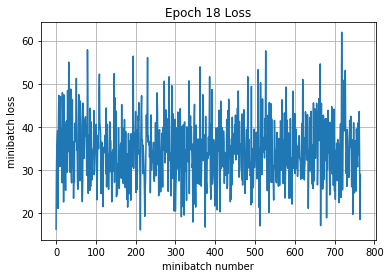

Iteration 13800: with minibatch training loss = 0.403 and accuracy of 0.81
Iteration 13900: with minibatch training loss = 0.705 and accuracy of 0.75
Iteration 14000: with minibatch training loss = 0.288 and accuracy of 0.88
Iteration 14100: with minibatch training loss = 0.631 and accuracy of 0.8
Iteration 14200: with minibatch training loss = 0.263 and accuracy of 0.89
Iteration 14300: with minibatch training loss = 0.316 and accuracy of 0.91
Iteration 14400: with minibatch training loss = 0.677 and accuracy of 0.78
Iteration 14500: with minibatch training loss = 0.546 and accuracy of 0.78
Epoch 19, Overall loss = 0.538 and accuracy of 0.812


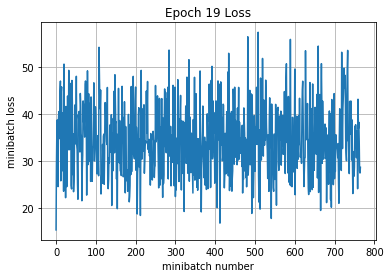

Iteration 14600: with minibatch training loss = 0.406 and accuracy of 0.83
Iteration 14700: with minibatch training loss = 0.754 and accuracy of 0.77
Iteration 14800: with minibatch training loss = 0.41 and accuracy of 0.83
Iteration 14900: with minibatch training loss = 0.447 and accuracy of 0.83
Iteration 15000: with minibatch training loss = 0.562 and accuracy of 0.8
Iteration 15100: with minibatch training loss = 0.348 and accuracy of 0.88
Iteration 15200: with minibatch training loss = 0.445 and accuracy of 0.89
Iteration 15300: with minibatch training loss = 0.373 and accuracy of 0.91
Epoch 20, Overall loss = 0.536 and accuracy of 0.811


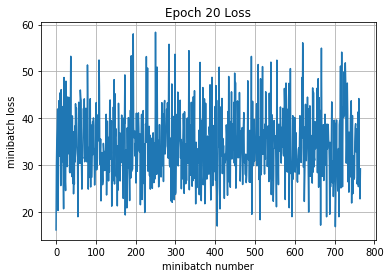

Iteration 15400: with minibatch training loss = 0.675 and accuracy of 0.77
Iteration 15500: with minibatch training loss = 0.355 and accuracy of 0.92
Iteration 15600: with minibatch training loss = 0.629 and accuracy of 0.78
Iteration 15700: with minibatch training loss = 0.508 and accuracy of 0.83
Iteration 15800: with minibatch training loss = 0.463 and accuracy of 0.83
Iteration 15900: with minibatch training loss = 0.523 and accuracy of 0.84
Iteration 16000: with minibatch training loss = 0.344 and accuracy of 0.88
Epoch 21, Overall loss = 0.533 and accuracy of 0.813


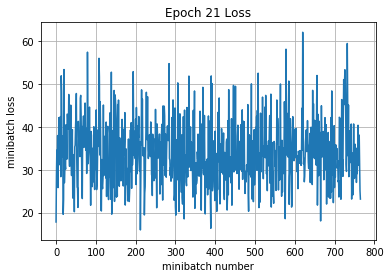

Iteration 16100: with minibatch training loss = 0.613 and accuracy of 0.84
Iteration 16200: with minibatch training loss = 0.486 and accuracy of 0.84
Iteration 16300: with minibatch training loss = 0.701 and accuracy of 0.78
Iteration 16400: with minibatch training loss = 0.507 and accuracy of 0.83
Iteration 16500: with minibatch training loss = 0.547 and accuracy of 0.81
Iteration 16600: with minibatch training loss = 0.692 and accuracy of 0.7
Iteration 16700: with minibatch training loss = 0.491 and accuracy of 0.84
Iteration 16800: with minibatch training loss = 0.449 and accuracy of 0.83
Epoch 22, Overall loss = 0.53 and accuracy of 0.813


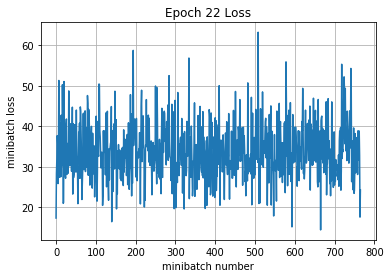

Iteration 16900: with minibatch training loss = 0.533 and accuracy of 0.78
Iteration 17000: with minibatch training loss = 0.729 and accuracy of 0.75
Iteration 17100: with minibatch training loss = 0.466 and accuracy of 0.86
Iteration 17200: with minibatch training loss = 0.717 and accuracy of 0.73
Iteration 17300: with minibatch training loss = 0.407 and accuracy of 0.89
Iteration 17400: with minibatch training loss = 0.437 and accuracy of 0.83
Iteration 17500: with minibatch training loss = 0.442 and accuracy of 0.84
Iteration 17600: with minibatch training loss = 0.619 and accuracy of 0.75
Epoch 23, Overall loss = 0.53 and accuracy of 0.814


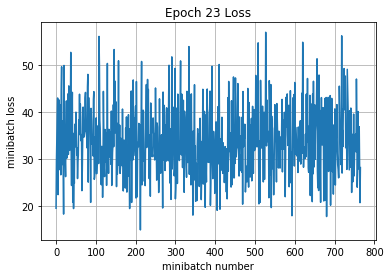

Iteration 17700: with minibatch training loss = 0.56 and accuracy of 0.77
Iteration 17800: with minibatch training loss = 0.727 and accuracy of 0.81
Iteration 17900: with minibatch training loss = 0.462 and accuracy of 0.88
Iteration 18000: with minibatch training loss = 0.543 and accuracy of 0.77
Iteration 18100: with minibatch training loss = 0.694 and accuracy of 0.77
Iteration 18200: with minibatch training loss = 0.462 and accuracy of 0.83
Iteration 18300: with minibatch training loss = 0.459 and accuracy of 0.86
Epoch 24, Overall loss = 0.53 and accuracy of 0.813


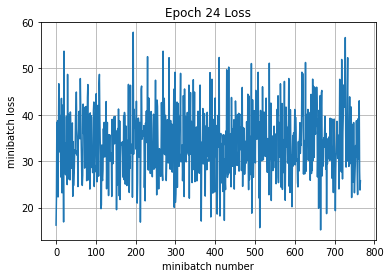

Iteration 18400: with minibatch training loss = 0.718 and accuracy of 0.78
Iteration 18500: with minibatch training loss = 0.44 and accuracy of 0.81
Iteration 18600: with minibatch training loss = 0.614 and accuracy of 0.78
Iteration 18700: with minibatch training loss = 0.623 and accuracy of 0.78
Iteration 18800: with minibatch training loss = 0.429 and accuracy of 0.86
Iteration 18900: with minibatch training loss = 0.515 and accuracy of 0.75
Iteration 19000: with minibatch training loss = 0.475 and accuracy of 0.81
Iteration 19100: with minibatch training loss = 0.434 and accuracy of 0.83
Epoch 25, Overall loss = 0.529 and accuracy of 0.814


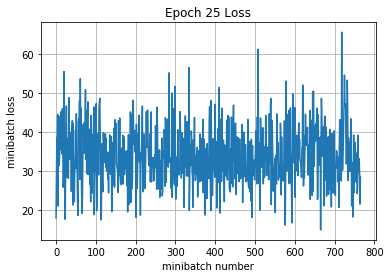

Iteration 19200: with minibatch training loss = 0.565 and accuracy of 0.78
Iteration 19300: with minibatch training loss = 0.654 and accuracy of 0.78
Iteration 19400: with minibatch training loss = 0.659 and accuracy of 0.83
Iteration 19500: with minibatch training loss = 0.467 and accuracy of 0.83
Iteration 19600: with minibatch training loss = 0.428 and accuracy of 0.86
Iteration 19700: with minibatch training loss = 0.543 and accuracy of 0.81
Iteration 19800: with minibatch training loss = 0.636 and accuracy of 0.78
Iteration 19900: with minibatch training loss = 0.39 and accuracy of 0.89
Epoch 26, Overall loss = 0.525 and accuracy of 0.814


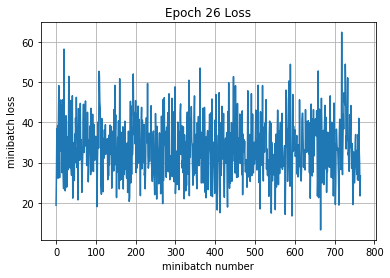

Iteration 20000: with minibatch training loss = 0.57 and accuracy of 0.8
Iteration 20100: with minibatch training loss = 0.407 and accuracy of 0.86
Iteration 20200: with minibatch training loss = 0.912 and accuracy of 0.72
Iteration 20300: with minibatch training loss = 0.414 and accuracy of 0.84
Iteration 20400: with minibatch training loss = 0.375 and accuracy of 0.86
Iteration 20500: with minibatch training loss = 0.564 and accuracy of 0.83
Iteration 20600: with minibatch training loss = 0.646 and accuracy of 0.78
Epoch 27, Overall loss = 0.52 and accuracy of 0.817


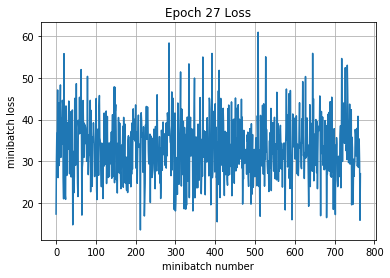

Iteration 20700: with minibatch training loss = 0.414 and accuracy of 0.8
Iteration 20800: with minibatch training loss = 0.417 and accuracy of 0.88
Iteration 20900: with minibatch training loss = 0.535 and accuracy of 0.78
Iteration 21000: with minibatch training loss = 0.376 and accuracy of 0.86
Iteration 21100: with minibatch training loss = 0.586 and accuracy of 0.8
Iteration 21200: with minibatch training loss = 0.534 and accuracy of 0.77
Iteration 21300: with minibatch training loss = 0.633 and accuracy of 0.77
Iteration 21400: with minibatch training loss = 0.869 and accuracy of 0.67
Epoch 28, Overall loss = 0.522 and accuracy of 0.817


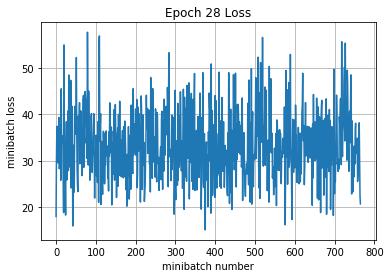

Iteration 21500: with minibatch training loss = 0.534 and accuracy of 0.81
Iteration 21600: with minibatch training loss = 0.377 and accuracy of 0.84
Iteration 21700: with minibatch training loss = 0.461 and accuracy of 0.84
Iteration 21800: with minibatch training loss = 0.563 and accuracy of 0.75
Iteration 21900: with minibatch training loss = 0.533 and accuracy of 0.88
Iteration 22000: with minibatch training loss = 0.648 and accuracy of 0.78
Iteration 22100: with minibatch training loss = 0.622 and accuracy of 0.78
Iteration 22200: with minibatch training loss = 0.575 and accuracy of 0.84
Epoch 29, Overall loss = 0.52 and accuracy of 0.817


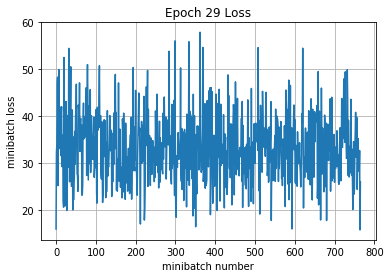

Iteration 22300: with minibatch training loss = 0.621 and accuracy of 0.81
Iteration 22400: with minibatch training loss = 0.598 and accuracy of 0.8
Iteration 22500: with minibatch training loss = 0.437 and accuracy of 0.83


In [ ]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,30,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)